In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.metrics import confusion_matrix    # 生成混淆矩阵函数
import os 
import itertools

In [2]:

#==============================================
#----------------adaboost----------------------
#==============================================

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
	"""
	单层决策树分类函数
	Parameters:
		dataMatrix - 数据矩阵
		dimen - 第dimen列，也就是第几个特征
		threshVal - 阈值
		threshIneq - 标志
	Returns:
		retArray - 分类结果
	"""
	retArray = np.ones((np.shape(dataMatrix)[0],1))				#初始化retArray为1
	if threshIneq == 'lt':
		retArray[dataMatrix[:,dimen] <= threshVal] = -1.0	 	#如果小于阈值,则赋值为-1
	else:
		retArray[dataMatrix[:,dimen] > threshVal] = -1.0		#如果大于阈值,则赋值为-1
	return retArray

def buildStump(dataArr,classLabels,D,numSteps = 20.0):
	"""
	找到数据集上最佳的单层决策树
	Parameters:
		dataArr - 数据矩阵
		classLabels - 数据标签
		D - 样本权重
        numSteps --步长
	Returns:
		bestStump - 最佳单层决策树信息
		minError - 最小误差
		bestClasEst - 最佳的分类结果
	"""
	dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
	m,n = np.shape(dataMatrix)
	bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
	minError = float('inf')														#最小误差初始化为正无穷大
	for i in range(n):															#遍历所有特征
		rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()		#找到特征中最小的值和最大值
		stepSize = (rangeMax - rangeMin) / numSteps								#计算步长
		for j in range(-1, int(numSteps) + 1): 									
			for inequal in ['lt', 'gt']:  										#大于和小于的情况，均遍历。lt:less than，gt:greater than
				threshVal = (rangeMin + float(j) * stepSize) 					#计算阈值
				predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
				errArr = np.mat(np.ones((m,1))) 								#初始化误差矩阵
				errArr[predictedVals == labelMat] = 0 							#分类正确的,赋值为0
				weightedError = D.T * errArr  									#计算误差
				# print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
				if weightedError < minError: 									#找到误差最小的分类方式
					minError = weightedError
					bestClasEst = predictedVals.copy()
					bestStump['dim'] = i
					bestStump['thresh'] = threshVal
					bestStump['ineq'] = inequal
	return bestStump, minError, bestClasEst

def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
	"""
	使用AdaBoost算法提升弱分类器性能
	Parameters:
		dataArr - 数据矩阵
		classLabels - 数据标签
		numIt - 最大迭代次数
	Returns:
		weakClassArr - 训练好的分类器
		aggClassEst - 类别估计累计值
	"""
	weakClassArr = []
	m = np.shape(dataArr)[0]
	D = np.mat(np.ones((m, 1)) / m)    										#初始化权重
	aggClassEst = np.mat(np.zeros((m,1)))
	for i in range(numIt):
		bestStump, error, classEst = buildStump(dataArr, classLabels, D) 	#构建单层决策树
		# print("D:",D.T)
		alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16))) 		#计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
		bestStump['alpha'] = alpha  										#存储弱学习算法权重 
		weakClassArr.append(bestStump)                  					#存储单层决策树
		# print("classEst: ", classEst.T)
		expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst) 	#计算e的指数项
		D = np.multiply(D, np.exp(expon))                           		   
		D = D / D.sum()														#根据样本权重公式，更新样本权重
		#计算AdaBoost误差，当误差为0的时候，退出循环
		aggClassEst += alpha * classEst  									#计算类别估计累计值								
		# print("aggClassEst: ", aggClassEst.T)
		aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1))) 	#计算误差
		errorRate = aggErrors.sum() / m
		# print("total error: ", errorRate)
		if errorRate == 0.0: break 											#误差为0，退出循环
	return weakClassArr, aggClassEst

def adaClassify(datToClass,classifierArr):
	"""
	AdaBoost分类函数
	Parameters:
		datToClass - 待分类样例
		classifierArr - 训练好的分类器
	Returns:
		分类结果
	"""
	dataMatrix = np.mat(datToClass)
	m = np.shape(dataMatrix)[0]
	aggClassEst = np.mat(np.zeros((m,1)))
	t_weight=0 
	for i in classifierArr:
		t_weight=t_weight+i['alpha']
	for i in range(len(classifierArr)):										#遍历所有分类器，进行分类
		classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])			
		aggClassEst += classifierArr[i]['alpha'] * classEst
	return aggClassEst/t_weight

In [3]:

#==============================================
#----------------特征工程----------------------
#==============================================

#定义对象型类别特征分类函数,需要注意是否单个类别的数据量是否过少，或者空值情况
def features_dict(data,c_list:list,nfold:list,y_label='flag'):
    """
    df:数据源
    c_list：需要分类的字段，为list形式
    nfold：为列表形式,采用Kmeans无监督学习，分类的类别数，-1为不分类仅为排序
    y_label：分类的标准
    return result_df_dict、result_df_list
    """
    df=data.copy()
    df.replace(np.nan,'null',inplace=True)
    result_df_list=pd.DataFrame( columns=['id','node', 'good', 'bad', 'total', 'good_pct', 'bad_pct', 'total_pct',
       'bad_rate', 'woe', 'iv', 'rank','section']  )
    result_df_dict={}  
    for i in range(len(c_list)):
        col_r=c_list[i]
        grouped=df.groupby(col_r)[y_label]
        result_df=grouped.agg([
                    ('good',lambda y:(y==0).sum()),
                    ('bad', lambda y:(y==1).sum()),
                    ('total','count')
                    ])
        result_df['good_pct']=result_df['good']/result_df['good'].sum()    
        result_df['bad_pct']=result_df['bad']/result_df['bad'].sum()   
        result_df['total_pct']=result_df['total']/result_df['total'].sum()        
        result_df['bad_rate']=result_df['bad']/result_df['total'].sum()
        result_df['woe']=np.log(result_df['good_pct']/result_df['bad_pct'])
        result_df['iv']=(result_df['good_pct']-result_df['bad_pct'])*result_df['woe']
        result_df['rank']=result_df['woe'].rank()
        result_df=result_df.sort_values(by='woe',axis=0,ascending=False)
        result_df=result_df.reset_index()
        result_df.insert(loc=0, column='id', value=col_r, allow_duplicates=False)
        result_df.rename(columns={col_r:'node'},inplace=True )
        if nfold[i]>0:
            X=result_df['woe'].values.reshape(-1,1)
            estimator = KMeans(n_clusters=nfold[i])#构造聚类器,分为nfold个类别
            estimator.fit(X)#聚类
            label_pred = estimator.labels_ #获取聚类标签
            result_df=pd.concat([result_df,pd.DataFrame(label_pred,columns=['section'])],axis=1)
            section_list=result_df['section'].tolist()
            section=0
            for j in range( result_df.shape[0]):
                if j==0 or section_list[j]==section_list[j-1]:
                    result_df.loc[j,'section']=section
                else:
                    section=section+1
                    result_df.loc[j,'section']=section
        else:
            result_df['section']=result_df['rank']
        #插入总计行   
        total_list=[[col_r,'合计',result_df['good'].sum(),result_df['bad'].sum(),result_df['total'].sum(),1,1,1
        ,result_df['bad'].sum()/result_df['total'].sum(),0,result_df['iv'].sum(),-999,-999]]
        total_list=pd.DataFrame(total_list, columns=['id','node', 'good', 'bad', 'total', 'good_pct', 'bad_pct', 'total_pct',
       'bad_rate', 'woe', 'iv', 'rank','section']  )
        result_df=result_df.append(total_list,ignore_index=True)
        #将替换字段字段化
        result_df['node']=result_df['node'].apply(lambda x : str(x))
        result_dict=dict(zip(result_df['node'],result_df['section']))
        #将result_dict,result_df合并
        result_df_dict.update({col_r:result_dict})
        result_df_list=result_df_list.append(result_df)
    return result_df_list,result_df_dict

#定义转换字段(类别型)
def features_dict_replace(df,c_dict:dict ):
    new_col_list=[]
    for i,j in c_dict.items():
        new_col=i+'_n'
        df[new_col]=df[i].apply(lambda x : str(x))
        df[new_col].replace(np.nan,'null',inplace=True)
        df.replace({new_col: j},inplace=True)
        new_col_list.append(new_col)
    return new_col_list

In [4]:
#==============================================
#----------------模型评估----------------------
#==============================================

#归一化函数
def normorlization_list(data:list):
    try:
        data=data.tolist()
        data=[x[0] for x in data ]
    except:
        pass
    value_max=max(data)
    value_min=min(data)
    nor_list=[(x-value_min)/(value_max-value_min) for x in data]
    return nor_list

#预测结果评估函数
def metrics_result(y_score,y_pred):
    precision, recall, thresholds = precision_recall_curve(y_score, y_pred)
    F1_score=2*(precision*recall)/(precision+recall)
    df_res=pd.DataFrame( (recall,precision,thresholds,F1_score),index=['recall','precision','thresholds','F1_score'] )
    df_res=df_res.T
    F1_score=df_res['F1_score'].max()
    result=df_res[df_res['F1_score']==F1_score].values[0]
    recall=result[0]
    precision=result[1]
    thresholds=result[2]
    F1_score=result[3]
    fpr,tpr,thresholds=roc_curve(y_score, y_pred)
    auc_score=roc_auc_score(y_score,y_pred)
    ks=0
    for i in range(len(fpr)):
        if ks<tpr[i]-fpr[i]:
            ks=tpr[i]-fpr[i]
            thres_hold=thresholds[i]
    y_pred=[1 if x>thres_hold else 0  for x in y_pred]
    acc_score=accuracy_score(y_score,y_pred)
    result={'auc':auc_score,'ks':ks,'recall':recall,'precise':precision,'F1_score':F1_score,'accuracy':acc_score}
    return result

#混淆矩阵绘图
def plot_confusion_matrix(y_score,y_pred, classes=['1','0'], normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    y_score,y_pred : 实际值和预测值
    classes : 混淆矩阵中每一行每一列对应的列
    normalize : True:显示百分比, False:显示个数
    """
    fpr,tpr,thresholds=roc_curve(y_score, y_pred)
    ks=0
    for i in range(len(fpr)):
        if ks<tpr[i]-fpr[i]:
            ks=tpr[i]-fpr[i]
            thres_hold=thresholds[i]
    y_pred=[1 if x>thres_hold else 0  for x in y_pred]
    if not isinstance(y_score,list):
        y_score=y_score.tolist()
    df_label=pd.DataFrame(list(zip(y_score,y_pred)),columns=['true','pred'])
    tp=df_label.query('true==1&pred==1').shape[0]
    tn=df_label.query('true==0&pred==0').shape[0]
    fp=df_label.query('true==0&pred==1').shape[0]
    fn=df_label.query('true==1&pred==0').shape[0]
    cm_df=pd.DataFrame( [[tp,fn],[fp,tn],[tp+fp,fn+tn]  ],columns=['预测为正','预测为反'],index=['真实为正','真实为反','总计'] )
    cm_df['总计']=cm_df['预测为正']+cm_df['预测为反']
    cm=cm_df.iloc[:2,:2].values
    cm=cm.T
    # cm=confusion_matrix(y_score, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.axis("equal")
    ax = plt.gca()  # 获得当前axis
    left, right = plt.xlim()  # 获得x轴最大最小值
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(i, j, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#AUC图像绘图
def auc_curve_plot(Ytrain,train_pred,title=''):
    fpr,tpr,thresholds=roc_curve(Ytrain, train_pred)
    auc_score=roc_auc_score(Ytrain,train_pred)
    plt.rc('font', family='Times New Roman')
    plt.plot(fpr, tpr, 'b', label='%s AUC = %0.4f' % (title,auc_score))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')  # the name of x-axis
    plt.ylabel('True Positive Rate')  # the name of y-axis
    plt.title('Receiver operating characteristic example')  # the title of figure
    plt.show()

In [11]:

#=====================================================
#--------------------数据预处理-----------------------
#=====================================================

os.chdir(r'C:\Users\Admin\Desktop\data')
df_train=pd.read_csv('./train.csv' )
data=df_train.copy()
data=data.rename({'Response':'flag'},axis=1)

In [12]:
data_info_list={}
#查看空值率：
data_info_list.update({'null_list':{col:data[col].isna().sum()/data.shape[0] for col in data.columns } } )
#查看疑似类别变量：
data_info_list.update({'object_list':{col:data[col].nunique() for col in data.columns if data[col].nunique() <= 50}})
cols=data.columns.tolist()
cols_str=[]
cols_var=[]
for i in cols:
    try:
        data.loc[:,i].astype('float')
        cols_var.append(i)
    except :
        cols_str.append(i)
#tmp=data['regionCode'].value_counts()
cols_tmp=['id']   
cols_str=cols_str+cols_tmp
cols_var=[x for x in cols_var if x not in cols_tmp ]

In [14]:
#将对象型类别特征转换，初步查看疑似类别对象的效果
str_list,str_dict=features_dict(data,['Driving_License','Gender','Previously_Insured'
                                      ,'Vehicle_Age','Vehicle_Damage'],nfold=[-1]*5 )                             
col_str_n=features_dict_replace(data,str_dict )
cols_var=cols_var+col_str_n

#数据预处理完成
dm=data[cols_var].copy()
dm=dm.astype(float)

In [15]:

#==================================================================
#------------------------2.1 模型训练------------------------------
#==================================================================

#划分训练集、测试集
Xtrain,Xtest,Ytrain,Ytest=train_test_split(dm.drop(columns='flag'),dm['flag']
                                            ,test_size=0.3,random_state=111)
Xtrain,Xtest=np.matrix(Xtrain.values),np.matrix(Xtest.values)
Ytrain,Ytest=Ytrain.tolist(),Ytest.tolist()
Ytrain1=[x if x==1.0 else -1.0 for x in Ytrain]

In [16]:

#模型训练       
weakClassArr, aggClassEst = adaBoostTrainDS(Xtrain, Ytrain1,numIt=100)
train_pred = adaClassify(Xtrain, weakClassArr)     
test_pred = adaClassify(Xtest, weakClassArr)  

In [17]:

#结果归一化
train_pred=normorlization_list(train_pred)
test_pred=normorlization_list(test_pred)


In [18]:
#结果评估
train_result=metrics_result(Ytrain,train_pred)
test_result=metrics_result(Ytest,test_pred)
print(train_result)
print(test_result)

{'auc': 0.8476825739688811, 'ks': 0.5885417537206384, 'recall': 0.7734803246057266, 'precise': 0.31450237202873826, 'F1_score': 0.44717879716020753, 'accuracy': 0.6996206555312322}
{'auc': 0.8476650028537882, 'ks': 0.581930385076978, 'recall': 0.783564567769477, 'precise': 0.31410073583937026, 'F1_score': 0.44843944051957574, 'accuracy': 0.7015122493068493}


In [19]:
#结果合并
y_label=pd.concat([pd.DataFrame(Ytrain,columns=['flag']),pd.DataFrame(Ytest,columns=['flag'])],axis=0)
y_pred=pd.concat([pd.DataFrame(train_pred,columns=['pred']),pd.DataFrame(test_pred,columns=['pred'])],axis=0)

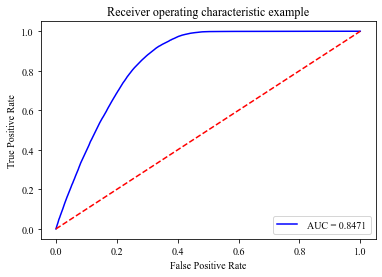

In [20]:
auc_curve_plot(y_label,y_pred)     #绘制ROC曲线

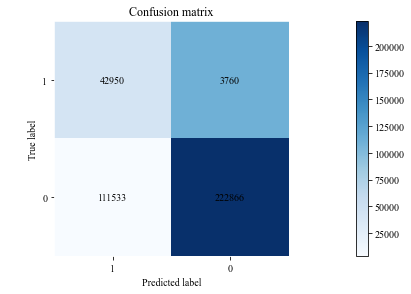

In [21]:
plot_confusion_matrix(y_label['flag'].tolist(),y_pred['pred'].tolist())     #绘制混淆矩阵

In [22]:
#================================================
#----------------2.2数据分析----------------------
#================================================

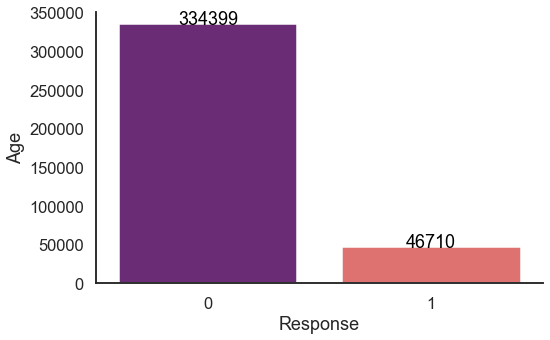

In [23]:
def barplot_plt(df,y_label,x_label,palette="husl"):
    """
    柱状图
    """
    sns.set(style="white",context="talk")
    fig,ax1 = plt.subplots(1,1,figsize=(8,5),sharex=True)
    df=df.groupby(x_label)[y_label].count()
    df=df.reset_index()
    g = sns.barplot(x=x_label, y=y_label,data=df, palette=palette, ax=ax1,ci =0)  
    # 显示具体值
    for index,row in df.iterrows():
        g.text(row.name,row[y_label]+2,round(row[y_label],1),color="black",ha="center")
    sns.despine(bottom=False,left=False)  # 设置是否显示边界线
barplot_plt(df_train,x_label="Response", y_label='Age',palette = 'magma')

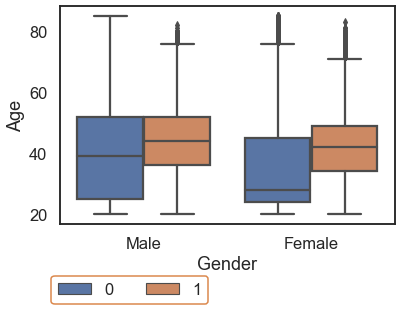

In [27]:
#箱型图
def boxplot_plt(data,x,y,hue=None,palette=None):
    plt.figure()
    ax=sns.boxplot(x=x,y=y,hue=hue ,data=data,palette=palette) 
    plt.legend(loc='upper left',bbox_to_anchor=(-0.05,-0.2),borderaxespad=0.5,ncol=5,edgecolor='chocolate')
    plt.show()

boxplot_plt(df_train,x="Gender", y="Age", hue="Response") #不同性别、是否应答的客户年龄箱型图

In [28]:

def violinplot_plt(df,y_label,x_label,hue_label,palette=None):
    """
    小提琴图绘图
    ___________________________________________________________________________________
    current_palette:可调整配色方案
    inner：控制violinplot内部数据点的表示，有“box”, “quartile”, “point”, “stick”四种方式。
    width：float，控制钢琴图的宽度（比例）
    """
    plt.rcParams['font.family']=['sans-serif'] #防止中文乱码
    plt.rcParams['font.sans-serif']=['SimHei']
    sns.set(style="whitegrid", palette="husl", color_codes=True)
    sns.set_context("poster")
    current_palette = sns.color_palette("Paired")
    sns.violinplot(x=x_label, y=y_label, hue=hue_label, data=df, split=True,
                inner="quart",vert=True,palette=palette)  
    plt.legend(loc='upper left',bbox_to_anchor=(0,-0.4),borderaxespad=0.5,ncol=5,edgecolor='chocolate') #设置图例
    plt.title('violinplot of %s '%y_label,fontsize=18)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    sns.despine(left=True)#删除图表边框 offset=10可设置与x轴距离
    plt.show()


def y_distribution_plt(data,y_label,x_label,hue_label=None,bins=50,color="r"):
    """
    分布图
    """
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
    plt.rcParams['font.family']=['sans-serif']
    plt.rcParams['font.sans-serif']=['SimHei']
    data=data[(data[x_label]<=100000) &(data[x_label]>0)]
    if hue_label:
        hue_label_list=data[hue_label].unique()
        for i,j in enumerate(hue_label_list):
            y_data=data[data[hue_label]==j]
            sns.distplot(y_data[x_label].values, axlabel =x_label, label =j, bins = bins, color=color[i])
    else:
        sns.distplot(data[x_label].values, axlabel =x_label, label =j, bins = bins, color=color)
    plt.setp(axes, yticks=[])
    plt.title('distplot of %s'%y_label,fontsize=18)
    plt.tight_layout()
    plt.xticks(np.linspace(0,100000,21)  )
    sns.despine(left=True)#删除图表边框
    plt.legend(loc='upper left',bbox_to_anchor=(0.95,0.95),borderaxespad=0.5,ncol=5,edgecolor='chocolate') #设置图例
    plt.show()

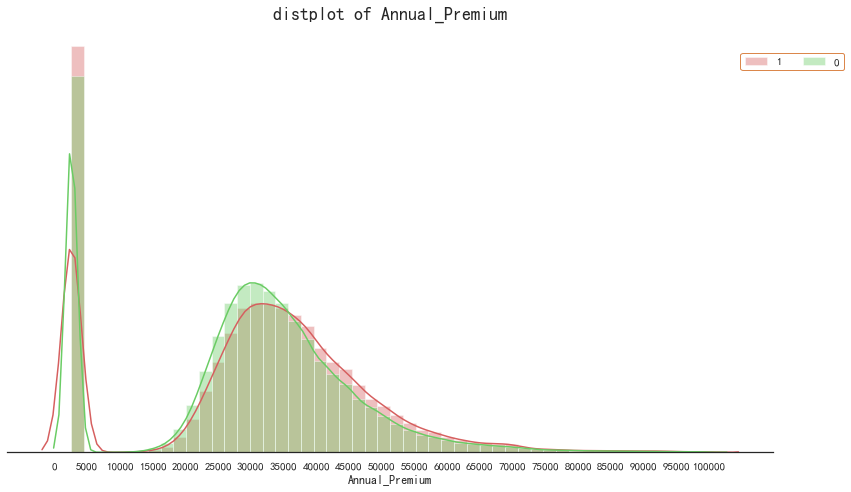

In [29]:
y_distribution_plt(df_train,x_label="Annual_Premium", y_label="Annual_Premium", hue_label="Response",color=['r','g']) 

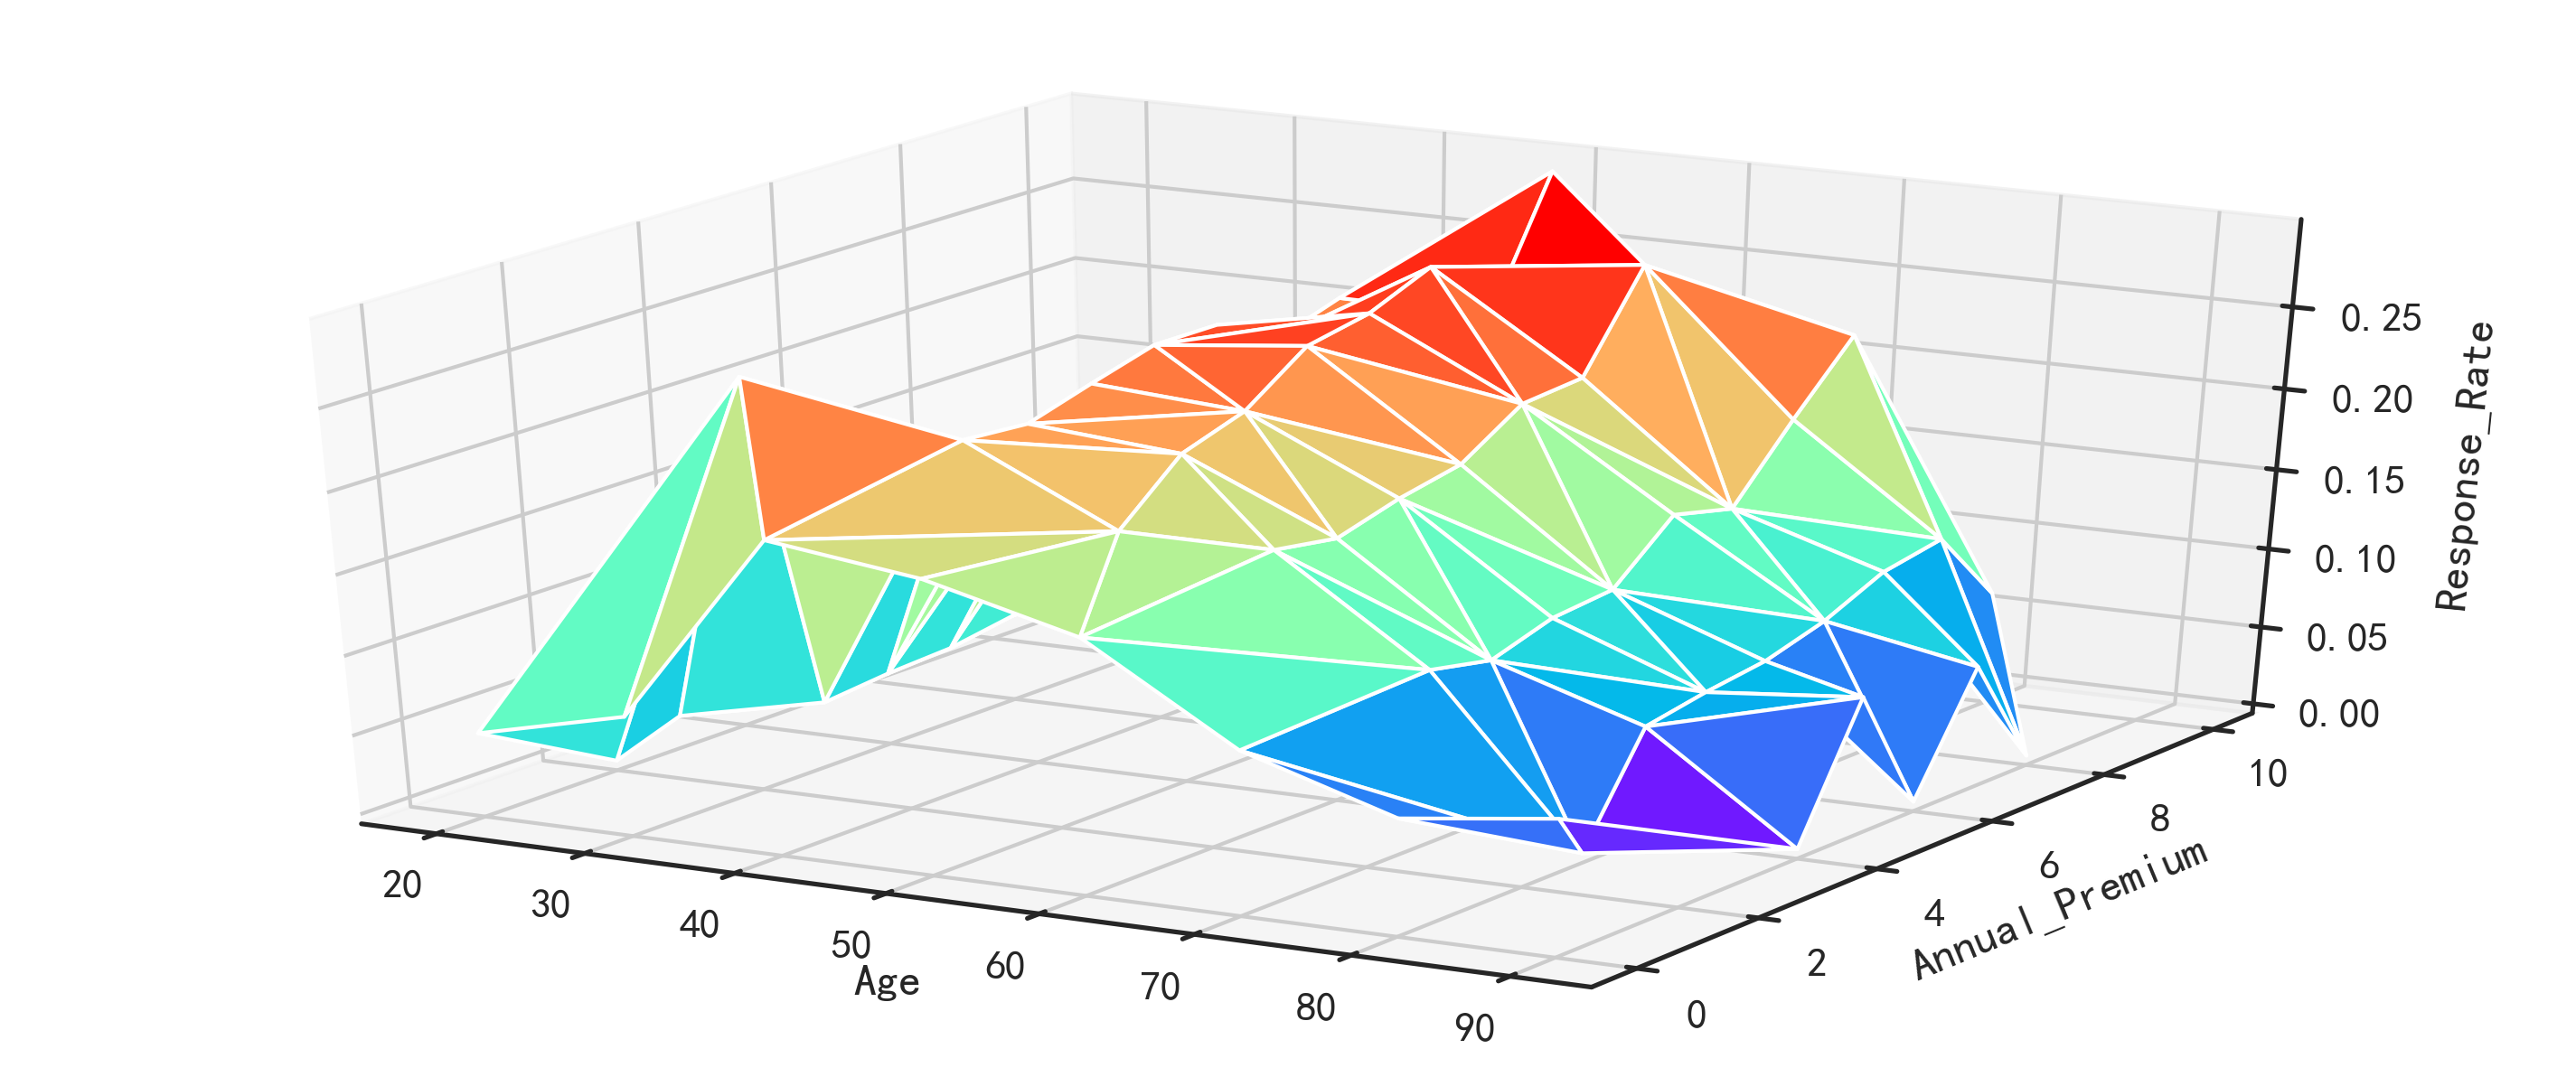

In [31]:
def axe3d_plt(x_data,y_data,z_data,xlabel,ylabel,zlabel,title=None,cmap='rainbow'):
    """
    3D图
    """
    sns.set(style='white')
    fig = plt.figure(figsize=(12,5), dpi=300)
    plt.rcParams['font.family']=['sans-serif']
    plt.rcParams['font.sans-serif']=['SimHei']
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(y_data,x_data,z_data,cmap=cmap)  #cmap选择rainbow会很好看，五彩斑斓
    #添加三个坐标系的标签
    ax.set_xlabel(xlabel,fontsize  = 12) 
    ax.set_ylabel(ylabel,fontsize  = 12) 
    ax.set_zlabel(zlabel,fontsize  = 12) 
    if  title:
        ax.set_title(title,fontsize  = 14)   

tmp=df_train.copy()
tmp['Age_cut']=pd.cut(x=df_train.Age,bins=[0,20,30,40,50,60,70,80,90,100],labels=[20,30,40,50,60,70,80,90,100])
tmp['Annual_Premium_cut']=pd.cut(x=df_train.Annual_Premium,bins=[0,3000,5000,10000,20000,30000,40000,50000,60000,80000,100000,1000000]
,labels=[0,1,2,3,4,5,6,7,8,9,10])
tmp=tmp.groupby(['Age_cut','Annual_Premium_cut'])['Response'].mean()
tmp=tmp.reset_index()
tmp=tmp.dropna(axis=0,how='any')
axe3d_plt(tmp['Annual_Premium_cut'].values,tmp['Age_cut'].values,tmp['Response'].values,'Age','Annual_Premium','Response_Rate')

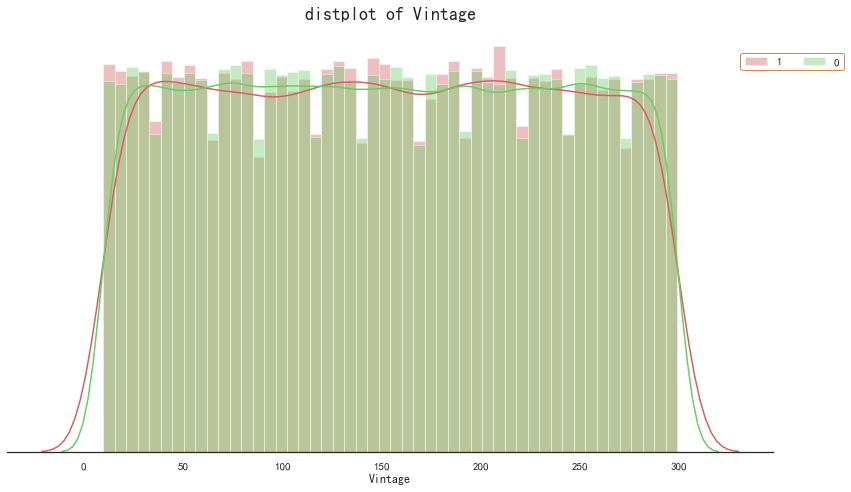

In [32]:

def y_distribution_plt(data,y_label,x_label,hue_label=None,bins=50,color="r"):
    """
    分布图
    """
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
    plt.rcParams['font.family']=['sans-serif']
    plt.rcParams['font.sans-serif']=['SimHei']
    data=data[(data[x_label]<=100000) &(data[x_label]>0)]
    if hue_label:
        hue_label_list=data[hue_label].unique()
        for i,j in enumerate(hue_label_list):
            y_data=data[data[hue_label]==j]
            sns.distplot(y_data[x_label].values, axlabel =x_label, label =j, bins = bins, color=color[i])
    else:
        sns.distplot(data[x_label].values, axlabel =x_label, label =j, bins = bins, color=color)
    plt.setp(axes, yticks=[])
    plt.title('distplot of %s'%y_label,fontsize=18)
    plt.tight_layout()
    sns.despine(left=True)#删除图表边框
    plt.legend(loc='upper left',bbox_to_anchor=(0.95,0.95),borderaxespad=0.5,ncol=5,edgecolor='chocolate') #设置图例
    plt.show()
y_distribution_plt(df_train,x_label="Vintage", y_label="Vintage", hue_label="Response",color=['r','g']) 

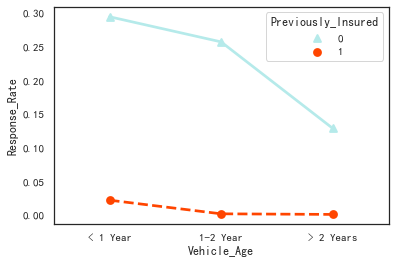

In [33]:

def pointplot_plt(df,y_label,x_label,hue_label,palette=None,markers=["^", "o"], linestyles=["-", "--"],xticks=None):
    """
    折线图
    """
    ax=sns.pointplot(x=x_label, y=y_label, hue=hue_label, data=df, 
                palette=palette,  # 颜色
                markers=markers, linestyles=linestyles);  # 数据点标记为三角、圆圈
    if xticks:
        xl=df[x_label].unique()
        plt.xticks(range(len(xl)),xticks )
tmp=df_train.groupby(['Previously_Insured','Vehicle_Age']).agg({'Response':[('yes',lambda y:(y==1).sum()),('no',lambda y:(y==0).sum())  ] } )
tmp=tmp['Response']
tmp['Response_Rate']=tmp['yes']/(tmp['no']+tmp['yes'])
tmp=tmp.reset_index()
tmp['Vehicle_Age']=tmp['Vehicle_Age'].replace(  str_dict['Vehicle_Age'])
tmp=tmp.sort_values(by=['Previously_Insured','Vehicle_Age'],ascending=True)
pointplot_plt(tmp,x_label="Vehicle_Age", y_label="Response_Rate"
, hue_label="Previously_Insured",palette=['#B5EAEA','#FF4500'],xticks=[ '< 1 Year','1-2 Year', '> 2 Years']) 

In [34]:
#生成变量特征重要性
importance_list={x:{'count':0,'gain':0 } for x in cols_var  }
for i in weakClassArr:
    cols_use=cols_var[i['dim']]
    alpha=i['alpha']
    importance_list[cols_use]['count']+=1
    importance_list[cols_use]['gain']+=alpha

importance_list=pd.DataFrame(importance_list).T
importance_list=importance_list.drop(index='flag',axis=0)
importance_list=importance_list.sort_values(by='count',ascending=False )

In [35]:
importance_list

,count,gain
Age,51.0,2.656951
Previously_Insured,16.0,0.952307
Region_Code,10.0,0.171650
Policy_Sales_Channel,7.0,0.181593
Annual_Premium,5.0,0.538718
Previously_Insured_n,5.0,0.165782
Vehicle_Age_n,4.0,0.652740
Vintage,1.0,0.011026
Driving_License_n,1.0,0.024122
Driving_License,0.0,0.000000
